In [1]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pymc3 as pm
data_folder = "titanic" # set to the name of the folder where you keep the data
test = pd.read_csv(os.path.join(data_folder, "test.csv"))
train = pd.read_csv(os.path.join(data_folder, "train_full.csv"))

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
# helper functions 
def binarize_cabin(df):
    cabins = df["Cabin"].values
    df["Cabin"] = [1 if isinstance(cabin, str) else 0 for cabin in cabins]
    return df

def binarize_gender(df):
    genders = df["Sex"].values
   # print(genders)
    df["Sex"] = [0 if x == "male" else 1 for x in genders]
    return df

In [5]:
# base model. 
def preprocessing(df): 
    # subset and binarize 
    sub = df[["Survived", "Pclass", "Sex", "Age", "Fare", "Cabin"]]
    df1 = binarize_cabin(sub)
    df2 = binarize_gender(sub)
    df2["Age"] = df2["Age"].fillna(df2["Age"].median())
    
    # split into outcome and predictors. 
    X = df2[["Pclass", "Sex", "Age", "Fare", "Cabin"]]
    Y = df2["Survived"]
    
    # min-max-scaling 
    min_max_scaler = MinMaxScaler()
    X[["Pclass", "Age", "Fare"]] = min_max_scaler.fit_transform(X[["Pclass", "Age", "Fare"]])
    
    # return stuff
    return(X, Y)


In [6]:
# generate for training. 
x, y = preprocessing(train)

In [7]:
# theano tensor import. 
import theano.tensor as T

# logistic 
def logistic(l):
    return 1 / (1 + T.exp(-l))

# make the model
basic_model = pm.Model()

with basic_model:
    
    #data = pm.Data('data', x)
    
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu = 0, sigma = 10)
    beta = pm.Normal("beta", mu = 0, sigma = 10, shape = 5) # shape = 3 since we have 3 predictors. 
    
    # Expected value of outcome
    mu = alpha + beta[0] * x.Pclass.values + beta[1] * x.Sex.values + beta[2] * x.Age.values + beta[3] * x.Fare.values + beta[4] * x.Cabin.values

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=logistic(mu), observed = y.values)


In [8]:
# map estimate
map_estimate = pm.find_MAP(model = basic_model)
map_estimate

{'alpha': array(0.47014107),
 'beta': array([-1.8520407 ,  2.60322152, -2.68180847, -0.05774161,  0.69350118])}

In [9]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 91 seconds.


In [10]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [beta]
>Slice: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 97 seconds.
The number of effective samples is smaller than 10% for some parameters.


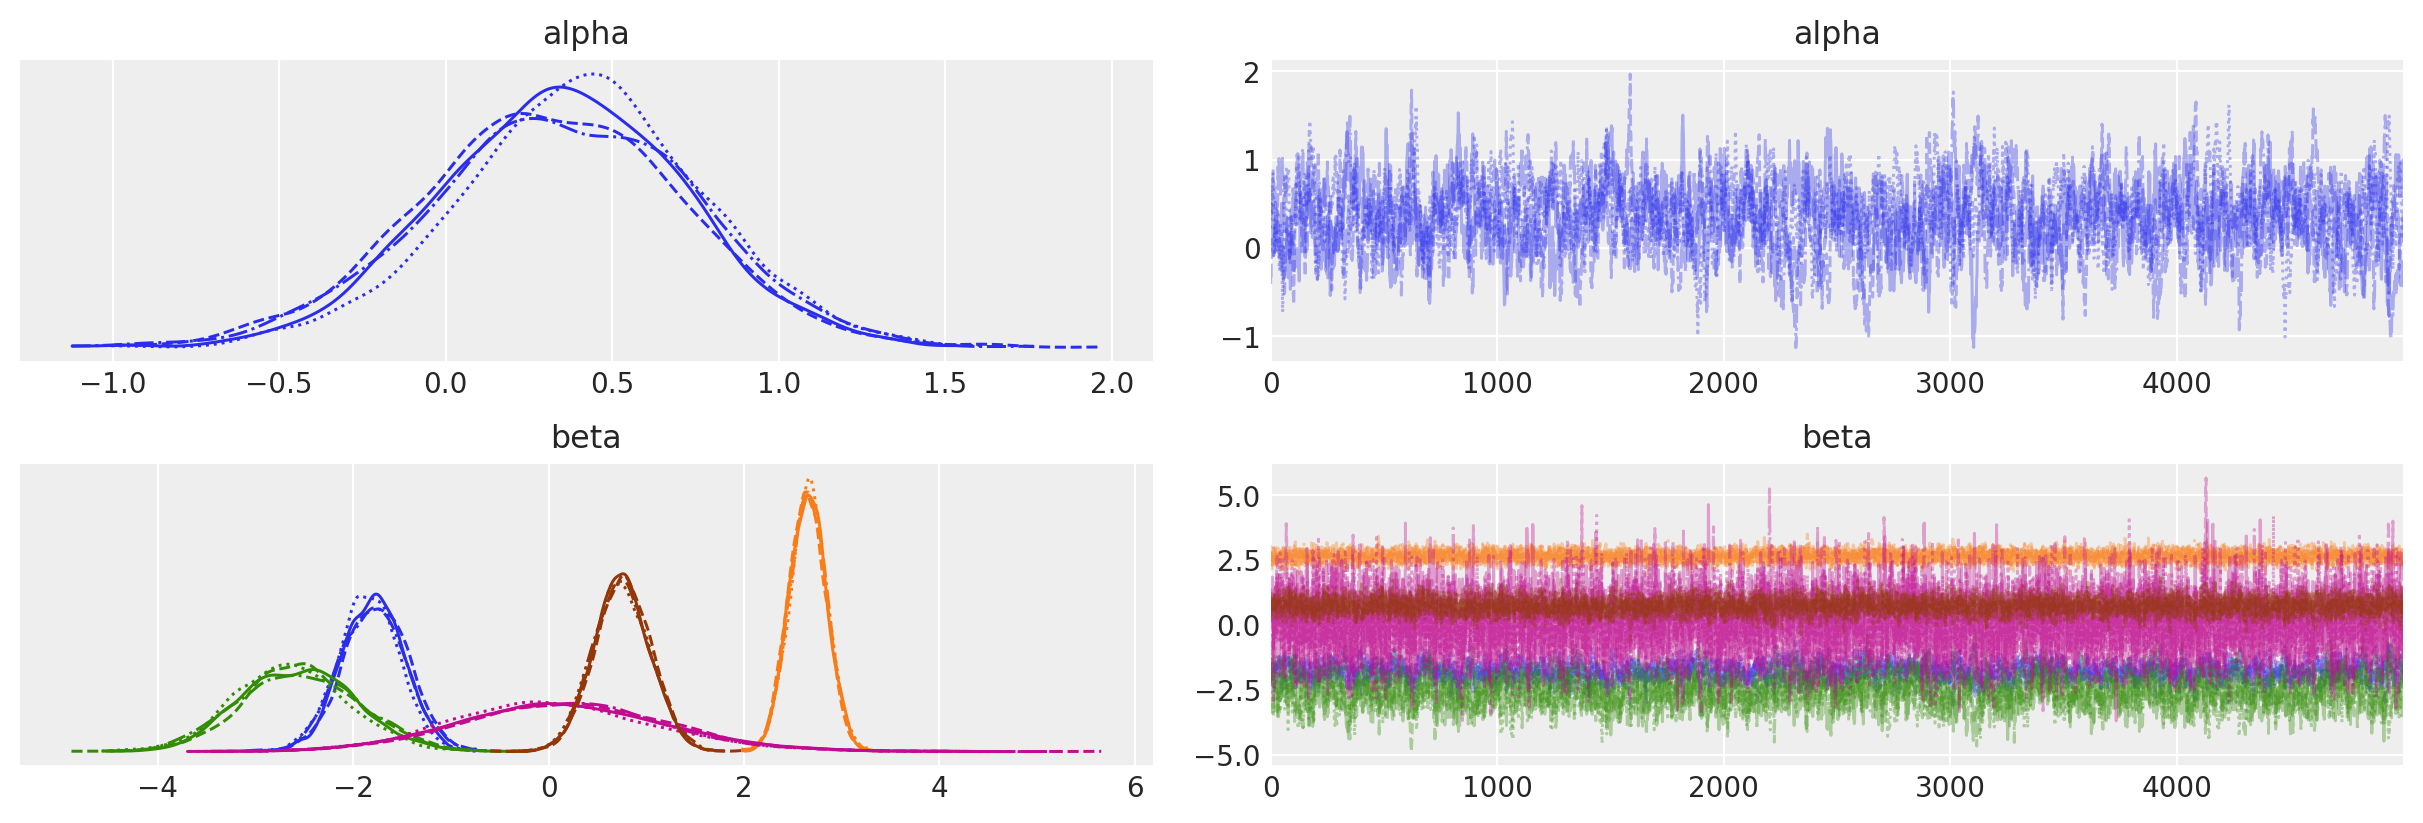

In [11]:
with basic_model:
    az.plot_trace(trace);

In [12]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.35,0.39,-0.37,1.09,0.01,0.01,673.57,673.57,680.19,1118.05,1.01
beta[0],-1.80,0.33,-2.42,-1.19,0.01,0.01,962.90,962.90,961.26,1909.24,1.00
beta[1],2.65,0.19,2.30,3.01,0.00,0.00,6729.89,6677.29,6734.85,8766.01,1.00
beta[2],-2.57,0.59,-3.69,-1.48,0.02,0.01,964.28,964.28,970.25,1930.23,1.00
beta[3],0.12,1.06,-1.91,2.10,0.02,0.01,3655.08,3655.08,3658.08,7911.67,1.00
beta[4],0.75,0.29,0.20,1.28,0.01,0.00,2221.42,2221.42,2223.56,6075.60,1.00


## prediction

In [21]:
train["Survived"].value_counts(normalize = True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [64]:
## on unseen data 
test = pd.read_csv(os.path.join(data_folder, "test.csv"))


c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [69]:
# sample from the model?
with basic_model:
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.


In [70]:
test

# 

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


In [ ]:
# new data 
with basic_model:
    # change the value and shape of the data
    pm.set_data(
        {
            "x_obs": [-1, 0, 1.0],
            # use dummy values with the same shape:
            "y_obs": [0, 0, 0],
        }
    )

    post_pred = pm.sample_posterior_predictive(idata.posterior)
    
    
with basic_model:
    
    #data = pm.Data('data', x)
    
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu = 0, sigma = 10)
    beta = pm.Normal("beta", mu = 0, sigma = 10, shape = 4) # shape = 3 since we have 3 predictors. 
    Pclass, Sex, Age, AgeSQ = beta[0], beta[1], beta[2], beta[3]
    
    # Expected value of outcome
    mu = alpha + Pclass * x.Pclass.values + Sex * x.Sex.values + Age * x.Age.values + AgeSQ * x.Age.values**2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=logistic(mu), observed = y.values)

In [61]:
## to-do: (1) scale predictors (2) add more predictors (3) predict. 
# sklearn.preprocessing.MinMaxScaler.fit_transform(df[[column]])